<h1 id="data">Seoul Bike Data - Linear Regression</h1>

**Table of content:**
1. Data preparation
2. Train a multiple linear regression model
3. Optimization of the linear regression model with interaction terms
4. Training / Testing of the linear regression model with polynomial interactions
5. Compute predictions for rented_bike_count based on MODEL 4


In [49]:
# Import all packages and libarys
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight') 

<h3 id="data">1. Data preparation</h3>

In [2]:
# Import the dataset
df = pd.read_csv('SeoulBikeData.csv', encoding='unicode_escape')

In [3]:
# Standardizing DataFrame column names
df.columns = df.columns.str.replace(r"\s*\(.*?\)\s*", "", regex=True)
df.columns = df.columns.str.replace(" ", "_", regex=False)
df.columns = [x.lower() for x in df.columns]

In [4]:
# Transform date to day, month, year and weekday
df["date"] = pd.to_datetime(df["date"], dayfirst = True)
df["day"] = df['date'].dt.day
df["month"] = df['date'].dt.month
df["year"] = df['date'].dt.year
df["weekday"] = df['date'].dt.day_name()

In [5]:
# Mapping Categorical Values to Numeric Representations
df['seasons'] = df['seasons'].map({'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3})
df['holiday'] = df['holiday'].map({"No Holiday": 0, "Holiday": 1})
df['weekday'] = df['weekday'].map({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7})

In [6]:
# Drop functioning day in the DataFrame
df=df.drop(['functioning_day'], axis = 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   8760 non-null   datetime64[ns]
 1   rented_bike_count      8760 non-null   int64         
 2   hour                   8760 non-null   int64         
 3   temperature            8760 non-null   float64       
 4   humidity               8760 non-null   int64         
 5   wind_speed             8760 non-null   float64       
 6   visibility             8760 non-null   int64         
 7   dew_point_temperature  8760 non-null   float64       
 8   solar_radiation        8760 non-null   float64       
 9   rainfall               8760 non-null   float64       
 10  snowfall               8760 non-null   float64       
 11  seasons                8760 non-null   int64         
 12  holiday                8760 non-null   int64         
 13  day

In [8]:
df.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,day,month,year,weekday
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,1,12,2017,5
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,1,12,2017,5
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,1,12,2017,5
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,1,12,2017,5
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,1,12,2017,5


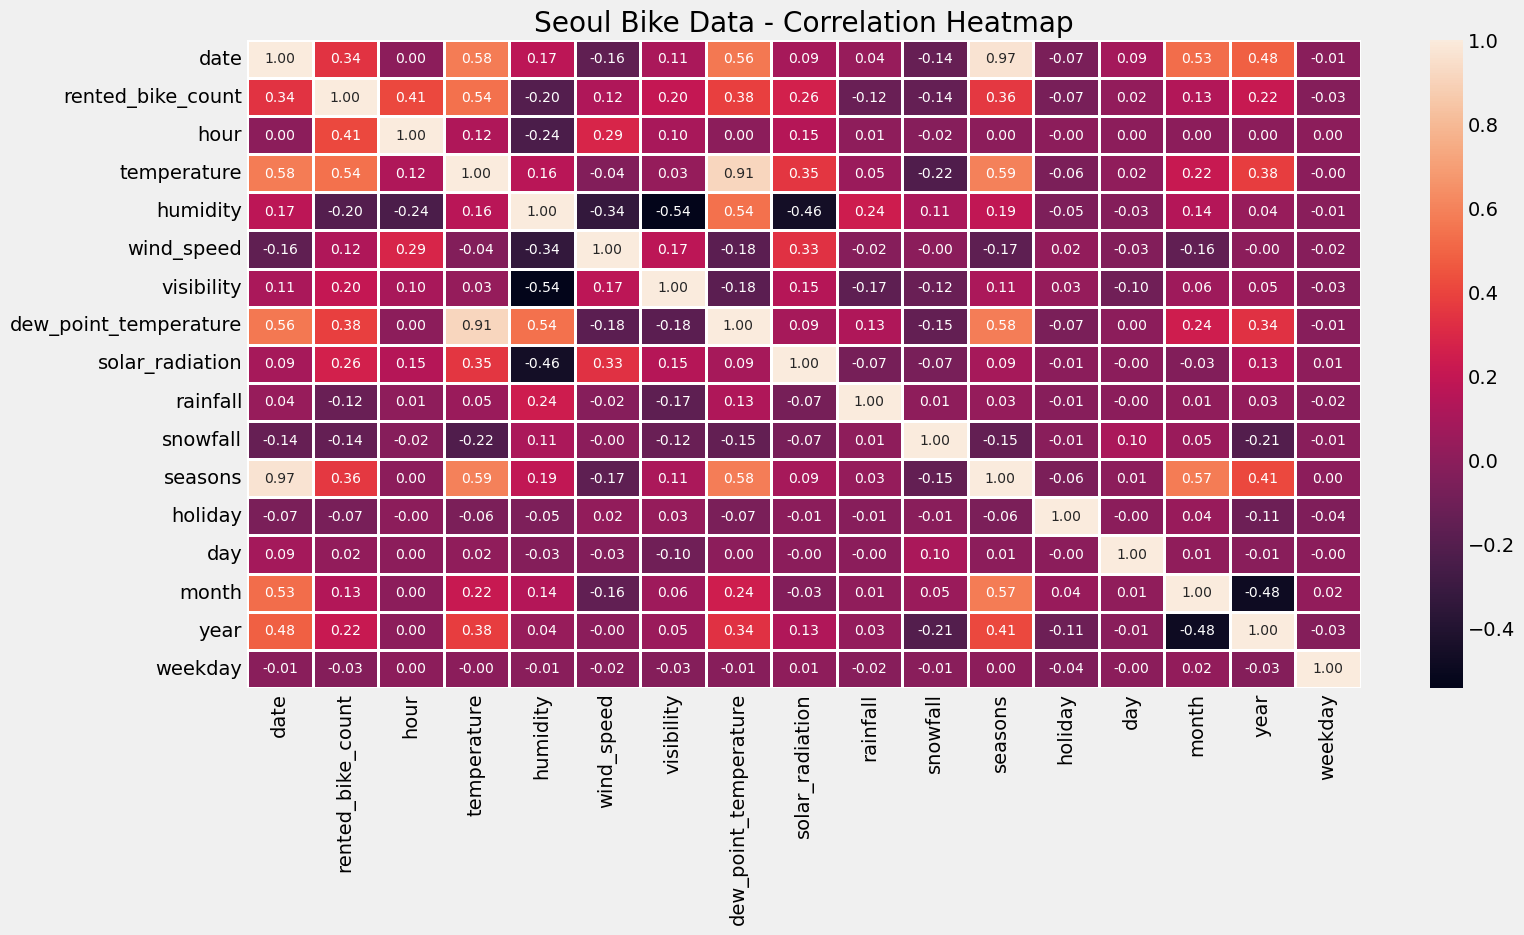

In [9]:
# Visualize the correlation matrix with the heatmap
fig, ax = plt.subplots(figsize = (16, 8))
sns.heatmap(df.corr(), annot = True, fmt = '1.2f', annot_kws = {'size' : 10}, linewidth = 1)
plt.title("Seoul Bike Data - Correlation Heatmap")
plt.show()

<h3 id="data">2. Train a multiple linear regression model</h3>

In [10]:
# Train a multiple linear regression model with all variables 
# MODEL 1
data_1 = df.columns.drop(['rented_bike_count', 'date'])
X_1 = MS(data_1).fit_transform(df)
y_1 = pd.DataFrame({'rented_bike_count': df['rented_bike_count']})
model_1 = sm.OLS(y_1, X_1)
results_1 = model_1.fit()
results_1.summary(model_1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                      OLS Regression Results                                                      
==================================================================================================================================
Dep. Variable:     <statsmodels.regression.linear_model.OLS object at 0x0000014A57FEFFE0>   R-squared:                       0.487
Model:                                                                                OLS   Adj. R-squared:                  0.486
Method:                                                                     Least Squares   F-statistic:                     553.0
Date:                                                                    Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                                                                            10:35:31   Log-Likelihood:                -66178.
No. Observations:                                                                    8760   AIC:                         1.324e+05
Df Residuals:                                                                        8744   BIC:                         1.325e+05
Df Model:                                                                              15                                         
Covariance Type:                                                                nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept              1.181e+06   1.49e+05      7.921      0.000    8.89e+05    1.47e+06
hour                     27.4141      0.778     35.228      0.000      25.889      28.940
temperature              24.4480      3.888      6.288      0.000      16.827      32.069
humidity                 -9.2005      1.100     -8.362      0.000     -11.357      -7.044
wind_speed               14.8383      5.448      2.724      0.006       4.159      25.518
visibility               -0.0035      0.011     -0.331      0.740      -0.024       0.017
dew_point_temperature     3.7032      4.084      0.907      0.365      -4.302      11.709
solar_radiation         -80.9207      8.120     -9.966      0.000     -96.837     -65.004
rainfall                -57.9896      4.566    -12.702      0.000     -66.939     -49.040
snowfall                 24.2322     12.049      2.011      0.044       0.612      47.852
seasons                 223.7551     20.145     11.107      0.000     184.266     263.244
holiday                -162.1877     23.036     -7.041      0.000    -207.343    -117.032
day                       0.2673      0.574      0.465      0.642      -0.858       1.393
month                   -52.8265      6.657     -7.936      0.000     -65.875     -39.778
year                   -585.0283     73.890     -7.918      0.000    -729.870    -440.187
weekday                 -10.6710      2.490     -4.286      0.000     -15.552      -5.790
==============================================================================
Omnibus:                      903.280   Durbin-Watson:                   0.451
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1854.119
Skew:                           0.662   Prob(JB):                         0.00
Kurtosis:                       4.824   Cond. No.                     7.56e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.56e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
# Drop visibility, dew_point_temperature and day, because the variables have high p-values
# MODEL 2
data_2 = df.columns.drop(['rented_bike_count', 'date', 'visibility', 'dew_point_temperature', 'day'])
X_2 = MS(data_2).fit_transform(df)
y_2 = pd.DataFrame({'rented_bike_count': df['rented_bike_count']})
model_2 = sm.OLS(y_2, X_2)
results_2 = model_2.fit()
results_2.summary(model_2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                      OLS Regression Results                                                      
==================================================================================================================================
Dep. Variable:     <statsmodels.regression.linear_model.OLS object at 0x0000014A58DD0CB0>   R-squared:                       0.487
Model:                                                                                OLS   Adj. R-squared:                  0.486
Method:                                                                     Least Squares   F-statistic:                     691.3
Date:                                                                    Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                                                                            10:35:40   Log-Likelihood:                -66178.
No. Observations:                                                                    8760   AIC:                         1.324e+05
Df Residuals:                                                                        8747   BIC:                         1.325e+05
Df Model:                                                                              12                                         
Covariance Type:                                                                nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept        1.184e+06   1.49e+05      7.944      0.000    8.92e+05    1.48e+06
hour               27.3975      0.774     35.386      0.000      25.880      28.915
temperature        27.9258      0.609     45.828      0.000      26.731      29.120
humidity           -8.2220      0.324    -25.408      0.000      -8.856      -7.588
wind_speed         14.4054      5.419      2.658      0.008       3.782      25.028
solar_radiation   -82.1607      7.674    -10.706      0.000     -97.204     -67.117
rainfall          -58.3904      4.532    -12.885      0.000     -67.273     -49.507
snowfall           24.2073     11.936      2.028      0.043       0.811      47.604
seasons           223.8438     20.110     11.131      0.000     184.423     263.264
holiday          -162.2725     23.032     -7.046      0.000    -207.421    -117.124
month             -52.9710      6.654     -7.960      0.000     -66.015     -39.927
year             -586.5457     73.866     -7.941      0.000    -731.340    -441.751
weekday           -10.8376      2.479     -4.371      0.000     -15.698      -5.978
==============================================================================
Omnibus:                      904.646   Durbin-Watson:                   0.451
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1857.559
Skew:                           0.663   Prob(JB):                         0.00
Kurtosis:                       4.825   Cond. No.                     6.09e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.09e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
# Compute the VIFs (Variance inflation factors)
vals = [VIF(X_2, i)  # Function vals with two arguments X: the dataframe or array and a variable column index
    for i in range(1, X_2.shape[1])] # Excluding the intercept value column 0 not being of interest
vif = pd.DataFrame({'vif':vals},
                  index=X_2.columns[1:])
vif 

,vif
hour,1.176829
temperature,2.170365
humidity,1.778653
wind_speed,1.292041
solar_radiation,1.820979
rainfall,1.070767
snowfall,1.113222
seasons,20.575350
holiday,1.018961
month,21.566357


In [14]:
# Drop month and year and train the linear regression model with seasons, as these features have high VIF values
# MODEL 3
data_3 = df.columns.drop(['rented_bike_count', 'date', 'visibility', 'dew_point_temperature', 'day', 'month', 'year'])
X_3 = MS(data_3).fit_transform(df)
y_3 = pd.DataFrame({'rented_bike_count': df['rented_bike_count']})
model_3 = sm.OLS(y_3, X_3)
results_3 = model_3.fit()
results_3.summary(model_3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                      OLS Regression Results                                                      
==================================================================================================================================
Dep. Variable:     <statsmodels.regression.linear_model.OLS object at 0x0000014A57FDD460>   R-squared:                       0.483
Model:                                                                                OLS   Adj. R-squared:                  0.482
Method:                                                                     Least Squares   F-statistic:                     817.3
Date:                                                                    Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                                                                            10:35:47   Log-Likelihood:                -66211.
No. Observations:                                                                    8760   AIC:                         1.324e+05
Df Residuals:                                                                        8749   BIC:                         1.325e+05
Df Model:                                                                              10                                         
Covariance Type:                                                                nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept         471.1522     27.366     17.216      0.000     417.508     524.797
hour               27.4504      0.776     35.380      0.000      25.929      28.971
temperature        27.8527      0.605     46.029      0.000      26.667      29.039
humidity           -8.0572      0.324    -24.870      0.000      -8.692      -7.422
wind_speed         14.9624      5.429      2.756      0.006       4.320      25.605
solar_radiation   -79.2151      7.693    -10.297      0.000     -94.295     -64.135
rainfall          -59.6534      4.544    -13.127      0.000     -68.562     -50.745
snowfall           21.0892     11.861      1.778      0.075      -2.161      44.339
seasons            69.0659      5.644     12.237      0.000      58.002      80.130
holiday          -158.5755     22.992     -6.897      0.000    -203.646    -113.505
weekday           -10.3466      2.486     -4.162      0.000     -15.219      -5.474
==============================================================================
Omnibus:                      909.715   Durbin-Watson:                   0.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1847.651
Skew:                           0.669   Prob(JB):                         0.00
Kurtosis:                       4.808   Cond. No.                         361.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# Identifying significant features based on correlation
corr = df.corr()
features = corr["rented_bike_count"]
significant_features = features[features.abs() > 0.199]
significant_features

date                     0.340772
rented_bike_count        1.000000
hour                     0.410257
temperature              0.538558
humidity                -0.199780
visibility               0.199280
dew_point_temperature    0.379788
solar_radiation          0.261837
seasons                  0.359687
year                     0.215162
Name: rented_bike_count, dtype: float64

In [16]:
# Train a linear regression model with the following features based on the significant_features
# MODEL 4
data_4 = df.columns.drop(['rented_bike_count', 'date', 'wind_speed', 'rainfall', 'snowfall', 'holiday', 'day', 'month', 'weekday'])
X_4 = MS(data_4).fit_transform(df)
y_4 = pd.DataFrame({'rented_bike_count': df['rented_bike_count']})
model_4 = sm.OLS(y_4, X_4)
results_4 = model_4.fit()
results_4.summary(model_4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                      OLS Regression Results                                                      
==================================================================================================================================
Dep. Variable:     <statsmodels.regression.linear_model.OLS object at 0x0000014A580EAF60>   R-squared:                       0.469
Model:                                                                                OLS   Adj. R-squared:                  0.469
Method:                                                                     Least Squares   F-statistic:                     966.3
Date:                                                                    Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                                                                            10:36:02   Log-Likelihood:                -66327.
No. Observations:                                                                    8760   AIC:                         1.327e+05
Df Residuals:                                                                        8751   BIC:                         1.327e+05
Df Model:                                                                               8                                         
Covariance Type:                                                                nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept              2.536e+04   4.07e+04      0.623      0.533   -5.44e+04    1.05e+05
hour                     27.4908      0.766     35.888      0.000      25.989      28.992
temperature              18.0511      3.911      4.616      0.000      10.385      25.717
humidity                -11.3838      1.092    -10.425      0.000     -13.524      -9.243
visibility                0.0013      0.011      0.121      0.903      -0.019       0.022
dew_point_temperature    10.2635      4.099      2.504      0.012       2.229      18.298
solar_radiation         -71.0104      7.965     -8.915      0.000     -86.624     -55.397
seasons                  69.4535      5.981     11.612      0.000      57.729      81.178
year                    -12.2161     20.174     -0.606      0.545     -51.761      27.329
==============================================================================
Omnibus:                      908.709   Durbin-Watson:                   0.413
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1842.231
Skew:                           0.669   Prob(JB):                         0.00
Kurtosis:                       4.804   Cond. No.                     2.03e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h3 id="data">3. Optimization of the linear regression model with interaction terms</h3>

In [45]:
# Train MODEL 4 with 6 linear interaction terms included (see interaction term tuples below)
# hour - temperature, hour - dew_point_temperature, hour - seasons, temperature - dew_point_temperature, temperature - seasons, hour - solar_radiation
# MODEL 5
data_5 = ['hour', 'temperature', 'humidity', 'visibility', 'dew_point_temperature', 'solar_radiation', 'seasons', 'year',
          ('hour','temperature'), ('hour','dew_point_temperature'), ('hour','seasons'), ('temperature','dew_point_temperature'),
          ('temperature','seasons'), ('hour','solar_radiation')]
X_5 = MS(data_5).fit_transform(df)
y_5 = pd.DataFrame({'rented_bike_count': df['rented_bike_count']})
model_5 = sm.OLS(y_5, X_5)
results_5 = model_5.fit()
results_5.summary(model_5)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                      OLS Regression Results                                                      
==================================================================================================================================
Dep. Variable:     <statsmodels.regression.linear_model.OLS object at 0x0000014A5BB51B50>   R-squared:                       0.534
Model:                                                                                OLS   Adj. R-squared:                  0.533
Method:                                                                     Least Squares   F-statistic:                     715.6
Date:                                                                    Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                                                                            11:02:25   Log-Likelihood:                -65756.
No. Observations:                                                                    8760   AIC:                         1.315e+05
Df Residuals:                                                                        8745   BIC:                         1.316e+05
Df Model:                                                                              14                                         
Covariance Type:                                                                nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
intercept                          7.489e+04   3.92e+04      1.912      0.056   -1871.425    1.52e+05
hour                                -14.5929      1.862     -7.838      0.000     -18.243     -10.943
temperature                         -52.8879      5.164    -10.241      0.000     -63.011     -42.765
humidity                            -16.4264      1.068    -15.375      0.000     -18.521     -14.332
visibility                            0.0496      0.010      4.739      0.000       0.029       0.070
dew_point_temperature                69.3989      5.146     13.486      0.000      59.311      79.487
solar_radiation                     -30.5623     31.371     -0.974      0.330     -92.057      30.932
seasons                              53.6732     12.126      4.426      0.000      29.903      77.443
year                                -36.2962     19.407     -1.870      0.061     -74.337       1.745
hour:temperature                      4.3433      0.211     20.630      0.000       3.931       4.756
hour:dew_point_temperature           -2.4971      0.182    -13.707      0.000      -2.854      -2.140
hour:seasons                          1.8025      0.787      2.289      0.022       0.259       3.346
temperature:dew_point_temperature    -0.3224      0.045     -7.206      0.000      -0.410      -0.235
temperature:seasons                  -2.8558      0.725     -3.941      0.000      -4.276      -1.435
hour:solar_radiation                 -1.7248      2.447     -0.705      0.481      -6.521       3.072
==============================================================================
Omnibus:                      882.383   Durbin-Watson:                   0.505
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2586.995
Skew:                           0.542   Prob(JB):                         0.00
Kurtosis:                       5.431   Cond. No.                     2.09e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+07. This might indicate that there are
strong multicollinear

In [47]:
# Train MODEL 4 with 6 polynomial interaction terms included (see interaction term tuples below)
# hour - temperature, hour - dew_point_temperature, hour - seasons, temperature - dew_point_temperature, temperature - seasons, hour - solar_radiation
# MODEL 6
data_6 = ['hour', 'temperature', 'humidity', 'visibility', 'dew_point_temperature', 'solar_radiation', 'seasons', 'year']
X_6_df = df[data_6]
y_6 = df['rented_bike_count']

# PolynomialFeatures für alle Variablen mit Interaktionstermen und Quadraten (Grad 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_6_poly = poly.fit_transform(X_6_df)

# Namen der neuen Polynomial Features extrahieren und in DataFrame umwandeln
poly_feature_names = poly.get_feature_names_out(data_6)
X_6 = pd.DataFrame(X_6_poly, columns=poly_feature_names)

# Das erweiterte Modell mit OLS trainieren
X_6 = sm.add_constant(X_6)  # Konstante hinzufügen
model_6 = sm.OLS(y_6, X_6)
results_6 = model_6.fit()

# Modellzusammenfassung anzeigen
print(results_6.summary())

                            OLS Regression Results                            
Dep. Variable:      rented_bike_count   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     280.3
Date:                Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:11:36   Log-Likelihood:                -65357.
No. Observations:                8760   AIC:                         1.308e+05
Df Residuals:                    8717   BIC:                         1.311e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

<h3 id="data">4. Training / Testing of the linear regression model with polynomial interactions</h3>

**MODEL 6** (8 features and multiple polynomial interaction terms) has the highest R^2 value, **the highest R^2 adjusted value** (takes into account the model complexity) and the lowest AIC value!\
But model 6 could lead to overfitting due to the many polynomial interaction terms.\
In the following we check the R^2 value of model 6 by splitting the training and testing data set.

In [56]:
# Splitting data_6 into training-dataset and test-dataset
X_train, X_test, y_train, y_test = train_test_split(X_6, y_6, test_size = 0.30, random_state = 1)

In [57]:
# Fitting training-dataset to model
model_6 = sm.OLS(y_6, X_6)
results_6 = LinearRegression().fit(X_train, y_train)

In [58]:
# Prediction of model
y_pred = results_6.predict(X_test)

In [59]:
# Training accuracy of model
results_6.score(X_train, y_train)

0.5767831877951035

In [60]:
# Test accuracy of model
results_6.score(X_test, y_test)

0.5656860236354422

In [61]:
# Print all the details 
print('MODEL 6 (Linear regression Model with 8 features and multiple polynomial interaction terms):')
print('----------------------------------------------------------------------------')
print('Model intercept: {}'
     .format(results_6.intercept_))
print('R-squared score (training): {:.3f}'
     .format(results_6.score(X_train, y_train)))
print('R-squared score (testing): {:.3f}'
     .format(results_6.score(X_test, y_test)))
print('----------------------------------------------------------------------------')
print('linear model coeff:\n{}'
     .format(results_6.coef_))

MODEL 6 (Linear regression Model with 8 features and multiple polynomial interaction terms):
----------------------------------------------------------------------------
Model intercept: -1785049.632658475
R-squared score (training): 0.577
R-squared score (testing): 0.566
----------------------------------------------------------------------------
linear model coeff:
[ 3.43688308e-03  7.86990831e+03  1.28723150e+05  4.36550429e+04
 -2.61714742e+02 -1.80426687e+05 -3.08572093e+05 -1.51091495e-01
 -3.12170260e-02 -1.43598880e-01 -1.92400764e+00 -1.48219599e+00
  2.76500173e-03  3.93249994e+00  1.24693402e+01  4.77419440e-01
 -3.83857965e+00  2.31728482e+00 -1.00146517e+00 -2.84482665e-02
 -4.58795119e+00  1.13497286e+01  2.69769390e+00 -6.37732536e+01
 -4.05158333e-01 -5.34336105e-03  7.20638597e-01  1.08475282e+01
  7.91600328e-02 -2.16064086e+01 -2.20710043e-05  2.15035584e-02
  5.17559078e-02 -2.93848635e-03  1.29996139e-01  2.09976447e+00
 -2.31784078e+01 -2.36311666e+00  8.94112834e

<h3 id="data">5. Compute predictions for rented_bike_count based on MODEL 4</h3>

In [66]:
# We use MODEL 4 to compute predictions for the rented_bike_count
data_4 = df.columns.drop(['rented_bike_count', 'date', 'wind_speed', 'rainfall', 'snowfall', 'holiday', 'day', 'month', 'weekday'])
design_4 = MS(data_4)
design_4 = design_4.fit(df)
x_4 = design_4.transform(df)
y_4 = pd.DataFrame({'rented_bike_count': df['rented_bike_count']})
model_4 = sm.OLS(y_4, X_4)
results_4 = model_4.fit()
results_4.summary(model_4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                      OLS Regression Results                                                      
==================================================================================================================================
Dep. Variable:     <statsmodels.regression.linear_model.OLS object at 0x0000014A65D39FD0>   R-squared:                       0.469
Model:                                                                                OLS   Adj. R-squared:                  0.469
Method:                                                                     Least Squares   F-statistic:                     966.3
Date:                                                                    Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                                                                            11:27:06   Log-Likelihood:                -66327.
No. Observations:                                                                    8760   AIC:                         1.327e+05
Df Residuals:                                                                        8751   BIC:                         1.327e+05
Df Model:                                                                               8                                         
Covariance Type:                                                                nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept              2.536e+04   4.07e+04      0.623      0.533   -5.44e+04    1.05e+05
hour                     27.4908      0.766     35.888      0.000      25.989      28.992
temperature              18.0511      3.911      4.616      0.000      10.385      25.717
humidity                -11.3838      1.092    -10.425      0.000     -13.524      -9.243
visibility                0.0013      0.011      0.121      0.903      -0.019       0.022
dew_point_temperature    10.2635      4.099      2.504      0.012       2.229      18.298
solar_radiation         -71.0104      7.965     -8.915      0.000     -86.624     -55.397
seasons                  69.4535      5.981     11.612      0.000      57.729      81.178
year                    -12.2161     20.174     -0.606      0.545     -51.761      27.329
==============================================================================
Omnibus:                      908.709   Durbin-Watson:                   0.413
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1842.231
Skew:                           0.669   Prob(JB):                         0.00
Kurtosis:                       4.804   Cond. No.                     2.03e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
# Create the data which we wish to make predictions and transform it to the model matrix
new_df = pd.DataFrame({
    'hour': [10, 15, 20],
    'temperature': [25.5, 18.0, 10.2],
    'humidity': [55, 70, 85],
    'visibility': [2000, 3000, 1500],
    'dew_point_temperature': [15.2, 12.5, 5.0],
    'solar_radiation': [0.7, 0.5, 0.2],
    'seasons': [2, 3, 1],
    'year': [2017, 2018, 2020]
})
prediction_df = design_4.transform(new_df)
prediction_df

,intercept,hour,temperature,humidity,visibility,dew_point_temperature,solar_radiation,seasons,year
0,1.0,10,25.5,55,2000,15.2,0.7,2,2017
1,1.0,15,18.0,70,3000,12.5,0.5,3,2018
2,1.0,20,10.2,85,1500,5.0,0.2,1,2020


In [70]:
# Getting the predictions 
new_predictions = results_4.get_prediction(prediction_df);
new_predictions.predicted_mean

array([1079.08203421,  955.39968715,  560.37317489])

In [72]:
# Predictions and confidence intervals
conf_int = pd.DataFrame(new_predictions.conf_int(alpha=0.05), columns=['confidence_low', 'confidence_high'])
predictions_df = pd.DataFrame({
    'predicted_mean': new_predictions.predicted_mean,
    'confidence_low': conf_int['confidence_low'].values,
    'confidence_high': conf_int['confidence_high'].values
})
predictions_df

,predicted_mean,confidence_low,confidence_high
0,1079.082034,1034.966589,1123.197480
1,955.399687,916.860197,993.939178
2,560.373175,465.660233,655.086117
